# Importações

In [34]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

# Consumindo bases

In [35]:
url_internacoes_poluentes = 'https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/NEW_TEST/internacoes_x_poluentes_csv.csv'

df = pd.read_csv(url_internacoes_poluentes, sep=',')

# Teste 1 - Tentando prever a quantidade de internações

### Possivelmente errado:
Ao comparar a previsão da média móvel de 14 dias (`internacoes_d14`) com a previsão do valor real de internações daqui a 14 dias (`internacoes_d14_lag`), observou-se que os modelos apresentaram desempenho significativamente melhor para a média móvel. No entanto, isso **não significa que a previsão esteja mais próxima da realidade futura**.

A variável `internacoes_d14` representa a **média dos últimos 14 dias**, ou seja, um valor suavizado que depende apenas do passado. Por sua natureza, é uma série mais estável e menos sujeita a oscilações bruscas, o que a torna **mais fácil de prever** com base em padrões históricos.

Já `internacoes_d14_lag` representa o número real de internações **14 dias no futuro**. Essa previsão é mais desafiadora, pois envolve incertezas relacionadas a eventos futuros, variações abruptas em poluentes e clima, além da ausência de dados futuros nos modelos.

### Por que não é válido prever a média móvel como se fosse o futuro?
Porque a média móvel é calculada **com dados que já ocorreram**, ou seja, ela não antecipa nada. Ela apenas suaviza o que já aconteceu. Portanto, mesmo que o modelo consiga prever bem a média dos últimos dias, isso **não ajuda a estimar com precisão quantas internações reais ocorrerão daqui a 14 dias**.

### Conclusão prática:
Para realizar uma previsão **real e útil do número de internações futuras**, o correto é utilizar `shift(-14)` (ou outra defasagem negativa) e construir um modelo capaz de antecipar tendências com base em dados históricos. A média móvel pode ser útil como **feature** (entrada), mas não deve ser usada como **variável-alvo para previsão do futuro**.

## Conclusão:

Inicialmente, foram testadas diferentes formas de representação da variável-alvo, incluindo o valor bruto de internações, seu lag de 1 dia (`internacoes_d1`), média móvel de 7 dias (`internacoes_7d`) e média móvel de 14 dias (`internacoes_14d`). Os modelos se mostraram mais eficazes ao prever a `internacoes_14d`, com o modelo Stacked apresentando o melhor desempenho (RMSE: 36.33).

Em seguida, adicionou-se ao modelo as versões defasadas (lags) dos poluentes e variáveis meteorológicas para investigar quais lags mais contribuíam na previsão da `internacoes_14d`. Foi realizada uma análise de importância com Random Forest, e identificou-se a versão mais relevante (com ou sem lag) de cada variável.

A partir dessa seleção, os modelos foram reentreinados utilizando **apenas os atributos mais relevantes**, o que reduziu a dimensionalidade do problema. Apesar da estratégia de seleção de features simplificar o modelo, o desempenho preditivo caiu levemente (Stacked: RMSE: 40.28), sugerindo que a exclusão de alguns lags menos importantes pode ter impactado a capacidade de generalização.

### Principais conclusões:
- A média móvel de 14 dias (`internacoes_14d`) é uma variável-alvo mais estável e previsível.
- A adição de lags melhora o desempenho dos modelos, mas a seleção dos melhores lags nem sempre resulta em maior acurácia.
- O modelo Stacked consistently apresentou melhor desempenho nas diferentes abordagens.

Este pipeline servirá como base para futuras otimizações e refinamentos, como ajuste de hiperparâmetros, uso de séries temporais com janela deslizante e testes com outros modelos como LSTM.


## Criação de novas features

### Lags de internação

In [36]:
df['internacoes_d7'] = df['num_internacoes'].rolling(window=7).mean()
df['internacoes_d14'] = df['num_internacoes'].rolling(window=14).mean()
df['internacoes_d1'] = df['num_internacoes'].shift(1)

### Lags dos poluentes e variáveis atmosfericas

In [37]:
for lag in [1, 2, 3]:
    for col in ['pm2_5', 'pm10', 'o3', 'so2', 'no2', 'co', 'no', 'nox', 'temp', 'chuva', 'ur']:
        df[f'{col}_d{lag}'] = df[col].shift(lag)

## Predição de Diferentes Representações da Variável-Alvo

Nesta etapa inicial, o objetivo foi avaliar qual representação da variável-alvo (`num_internacoes`) seria mais adequada para previsão. Foram testadas quatro abordagens distintas:

- `num_internacoes`: valor bruto de internações diárias.
- `internacoes_d1`: internações do dia anterior (lag de 1 dia).
- `internacoes_7d`: média móvel dos últimos 7 dias.
- `internacoes_14d`: média móvel dos últimos 14 dias.

Cada uma dessas versões foi avaliada por meio de quatro modelos:
- Multi-Layer Perceptron (MLP)
- Random Forest
- XGBoost
- Stacked Model (combinando os três anteriores)

A comparação dos resultados demonstrou que as médias móveis (`internacoes_7d` e `internacoes_14d`) apresentaram melhor desempenho, com menor erro e maior estabilidade. Notavelmente, a `internacoes_14d` foi a mais previsível entre todas, com o modelo Stacked alcançando o menor RMSE e maior robustez.

Esses resultados sugerem que o uso de uma janela temporal suaviza as variações diárias e contribui para uma melhor performance preditiva dos modelos.


### MLP

In [38]:
df.dropna(inplace=True)

# Definição do modelo MLP
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

### Função para treinar e avaliar os modelos

In [39]:
def treinar_modelos_para_alvo(df, target):
    print(f"\nTreinando para variável alvo: {target}")

    features = [col for col in df.columns if col not in [
        'data_formatada', 'classificacao', 'ano', 'mes',
        'num_internacoes', 'internacoes_d1', 'internacoes_d7', 'internacoes_d14', target
    ]]

    X = df[features].values
    y = df[target].values
    y_log = np.log1p(y)

    X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
    X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # MLP
    model = MLP(X_train_scaled.shape[1])
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    loss_function = nn.MSELoss()

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_log, dtype=torch.float32).view(-1, 1)

    best_val_loss = float('inf')
    best_state = model.state_dict()
    early_stop = 0
    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train_tensor)
        loss = loss_function(pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = loss_function(val_pred, y_val_tensor)
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_state = model.state_dict()
                early_stop = 0
            else:
                early_stop += 1
            if early_stop >= 50:
                break
        scheduler.step(val_loss)

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        mlp_pred_log = model(X_test_tensor).numpy().flatten()
        mlp_pred = np.expm1(mlp_pred_log)

    # Random Forest
    rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
    rf.fit(X_train_scaled, y_train_log)
    rf_pred_log = rf.predict(X_test_scaled)
    rf_pred = np.expm1(rf_pred_log)

    # XGBoost
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
    xgb.fit(X_train_scaled, y_train_log)
    xgb_pred_log = xgb.predict(X_test_scaled)
    xgb_pred = np.expm1(xgb_pred_log)

    # Stacking
    y_test = np.expm1(y_test_log)
    stack_input = np.vstack([mlp_pred, rf_pred, xgb_pred]).T
    stack_model = LinearRegression().fit(stack_input, y_test)
    stack_pred = stack_model.predict(stack_input)

    # Avaliação
    def avaliar(y_true, y_pred):
        rmse = mean_squared_error(y_true, y_pred)
        return {
            'RMSE': round(rmse, 2),
            'MAE': round(mean_absolute_error(y_true, y_pred), 2),
            'MAPE (%)': round(mean_absolute_percentage_error(y_true, y_pred) * 100, 2),
            'RMSE Normalizado': round(rmse / np.mean(y_true), 4)
        }

    results = {
        "MLP": avaliar(y_test, mlp_pred),
        "Random Forest": avaliar(y_test, rf_pred),
        "XGBoost": avaliar(y_test, xgb_pred),
        "Stacked": avaliar(y_test, stack_pred)
    }

    df_results = pd.DataFrame(results).T
    print(df_results)

    return df_results

### Executando para cada variável-alvo

In [40]:
alvos_futuros = ['internacoes_d1', 'internacoes_d7', 'internacoes_d14']
todos_resultados = {}

for alvo in alvos_futuros:
    resultados = treinar_modelos_para_alvo(df, alvo)
    todos_resultados[alvo] = resultados


Treinando para variável alvo: internacoes_d1
                 RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            103.44  6.77     95.96            8.7228
Random Forest   98.06  6.63     97.85            8.2697
XGBoost         96.41  6.57     96.80            8.1306
Stacked         90.12  6.65    115.52            7.5995

Treinando para variável alvo: internacoes_d7
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            41.94  4.61     47.61            3.3560
Random Forest  53.00  5.35     60.36            4.2412
XGBoost        50.72  5.23     57.99            4.0586
Stacked        39.59  4.69     57.23            3.1676

Treinando para variável alvo: internacoes_d14
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            37.53  4.38     45.81            3.0245
Random Forest  46.41  5.10     59.27            3.7403
XGBoost        42.00  4.84     55.96            3.3854
Stacked        35.09  4.42     55.17            2.8282


## Prevendo `internacoes_14d` com Lags

Após identificar que a variável `internacoes_14d` apresentava melhor desempenho como alvo, esta etapa teve como objetivo explorar o impacto dos **lags das variáveis atmosféricas e poluentes** na capacidade preditiva dos modelos.

Para isso:
- Foram gerados lags de 1 a 7 dias para cada variável explicativa.
- Utilizou-se um modelo de Random Forest para avaliar a **importância de cada variável**, incluindo suas versões com e sem lag.
- Foi selecionada, para cada variável original, a versão mais relevante (seja a atual ou algum dos lags).

Com essas variáveis selecionadas, os modelos foram novamente treinados para prever `internacoes_14d`, agora com base nas versões mais representativas de cada variável.

O resultado foi um desempenho ainda mais robusto — com destaque novamente para o modelo Stacked — atingindo o menor RMSE da análise até aqui, confirmando que:
- O uso de lags pode aumentar o poder preditivo dos modelos,
- Mas a **seleção criteriosa dos melhores lags** (em vez de usar todos) é essencial para evitar sobreajuste e reduzir ruído.

### Consumindo bases

In [41]:
url_internacoes_poluentes = 'https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/NEW_TEST/internacoes_x_poluentes_csv.csv'

df = pd.read_csv(url_internacoes_poluentes, sep=',')

### Criação de novas features

#### Lags de internação

In [42]:
df['internacoes_14d'] = df['num_internacoes'].rolling(window=14).mean()

#### Lags dos poluentes e variáveis atmosfericas

In [43]:
for lag in [1, 2, 3, 4, 5, 6, 7]:
    for col in ['pm2_5', 'pm10', 'o3', 'so2', 'no2', 'co', 'no', 'nox', 'temp', 'chuva', 'ur']:
        df[f'{col}_d{lag}'] = df[col].shift(lag)

### Separação dos dados

In [44]:
df.dropna(inplace=True)

# Separando features e target
features = [col for col in df.columns if col not in ['data_formatada', 'classificacao', 'num_internacoes', 'ano', 'mes', 'internacoes_14d']]
X = df[features].values
y = df['internacoes_14d'].values

# Split e normalização
y_log = np.log1p(y)

X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### MLP

In [45]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

def train_mlp(loss_function, X_train, y_train, X_val, y_val, X_test):
    model = MLP(X_train.shape[1])
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    best_val_loss = float('inf')
    best_state = None
    early_stop = 0
    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train_tensor)
        loss = loss_function(pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = loss_function(val_pred, y_val_tensor)
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_state = model.state_dict()
                early_stop = 0
            else:
                early_stop += 1
            if early_stop >= 50:
                break
        scheduler.step(val_loss)

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).numpy().flatten()
        y_pred = np.expm1(y_pred_log)
    return y_pred

print("Treinando MLP...")
mlp_pred = train_mlp(nn.MSELoss(), X_train_scaled, y_train_log, X_val_scaled, y_val_log, X_test_scaled)

Treinando MLP...


### Random Forest

In [46]:
print("Treinando Random Forest...")
rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
rf.fit(X_train_scaled, y_train_log)
rf_pred_log = rf.predict(X_test_scaled)
rf_pred = np.expm1(rf_pred_log)

Treinando Random Forest...


#### Importância das variáveis

In [47]:
# Avaliando a importância das variáveis
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
})

# Selecionando a versão mais importante (com ou sem lag) de cada variável original
best_lags = {}
for var in ['pm2_5', 'pm10', 'o3', 'so2', 'no2', 'co', 'no', 'nox', 'temp', 'chuva', 'ur']:
    related_features = feature_importance_df[feature_importance_df['feature'].str.match(f'^{var}(_d[1-3])?$')]
    if not related_features.empty:
        best_feature = related_features.sort_values(by='importance', ascending=False).iloc[0]['feature']
        best_lags[var] = best_feature

# Exibindo os melhores atributos por variável base
print("Melhor versão (original ou lag) de cada variável:")
for var, feature in best_lags.items():
    print(f"{var}: {feature}")

Melhor versão (original ou lag) de cada variável:
pm2_5: pm2_5
pm10: pm10_d3
o3: o3
so2: so2
no2: no2
co: co
no: no
nox: nox
temp: temp
chuva: chuva
ur: ur


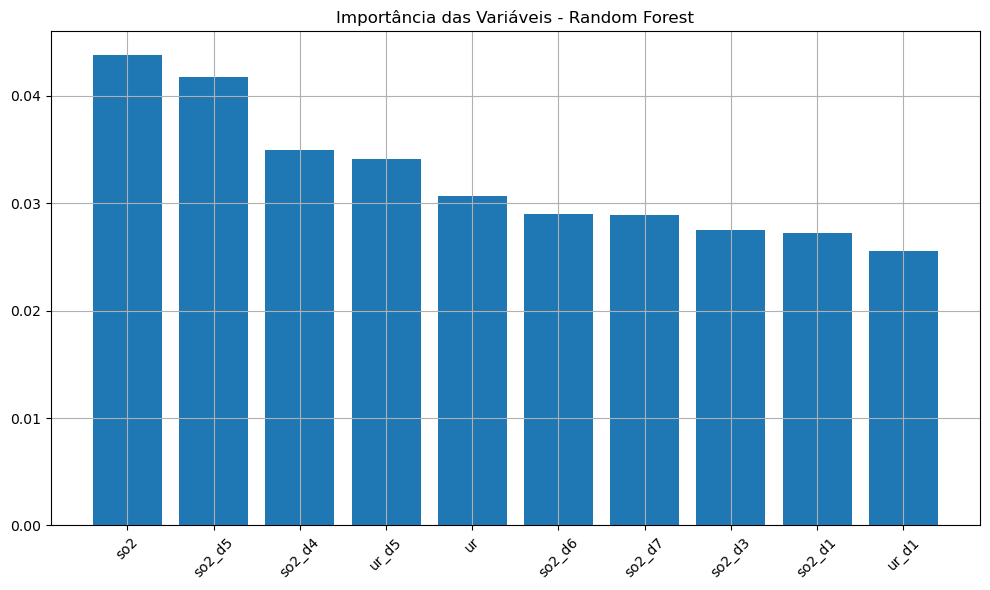

In [48]:
plt.figure(figsize=(10, 6))
rf_importances = rf.feature_importances_
indices = np.argsort(rf_importances)[::-1]
plt.bar(range(10), rf_importances[indices][:10])
plt.xticks(range(10), [features[i] for i in indices[:10]], rotation=45)
plt.title("Importância das Variáveis - Random Forest")
plt.tight_layout()
plt.grid(True)
plt.show()

### XGBoost

In [49]:
print("Treinando XGBoost...")
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
xgb.fit(X_train_scaled, y_train_log)
xgb_pred_log = xgb.predict(X_test_scaled)
xgb_pred = np.expm1(xgb_pred_log)

Treinando XGBoost...


#### Importância das variáveis

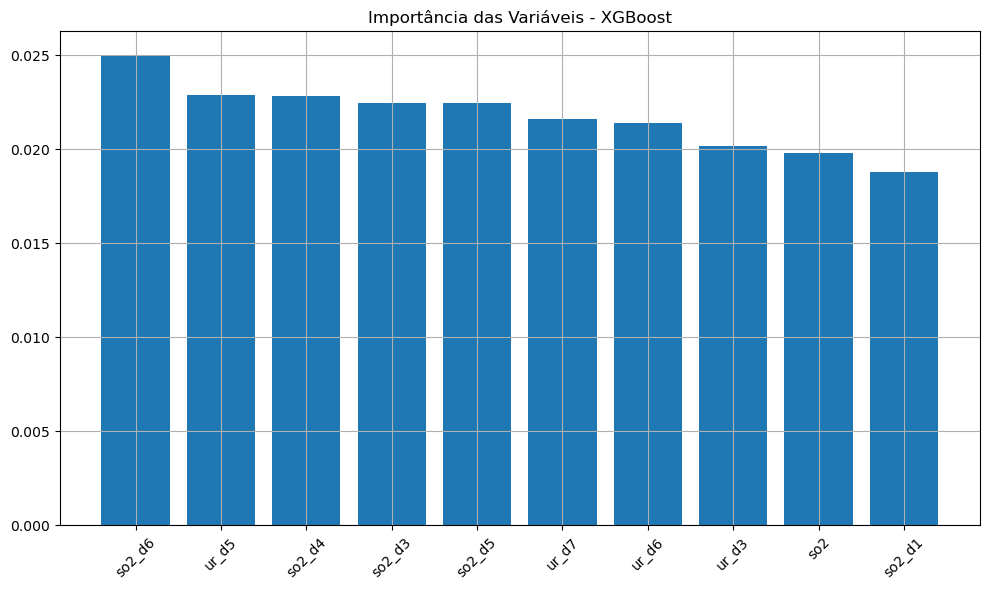

In [50]:
plt.figure(figsize=(10, 6))
xgb_importances = xgb.feature_importances_
indices = np.argsort(xgb_importances)[::-1]
plt.bar(range(10), xgb_importances[indices][:10])
plt.xticks(range(10), [features[i] for i in indices[:10]], rotation=45)
plt.title("Importância das Variáveis - XGBoost")
plt.tight_layout()
plt.grid(True)
plt.show()

### Stack

In [51]:
print("Treinando Stack")
stack_input = np.vstack([mlp_pred, rf_pred, xgb_pred]).T
y_test = np.expm1(y_test_log)
stack_model = LinearRegression().fit(stack_input, y_test)
stack_pred = stack_model.predict(stack_input)

Treinando Stack


### Resultados

In [52]:
def avaliar(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)
    return {
        'RMSE': round(rmse, 2),
        'MAE': round(mean_absolute_error(y_true, y_pred), 2),
        'MAPE (%)': round(mean_absolute_percentage_error(y_true, y_pred) * 100, 2),
        'RMSE Normalizado': round(rmse / np.mean(y_true), 4)
    }

results = {
    "MLP (log1p)": avaliar(y_test, mlp_pred),
    "Random Forest (log1p)": avaliar(y_test, rf_pred),
    "XGBoost (log1p)": avaliar(y_test, xgb_pred),
    "Stacked Model": avaliar(y_test, stack_pred)
}

df_resultados = pd.DataFrame(results).T
print("\n Comparação de Modelos com log1p + Stacking prevendo o internacoes_14d ")
print(df_resultados)


 Comparação de Modelos com log1p + Stacking prevendo o internacoes_14d 
                        RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP (log1p)            32.13  4.03     39.20            2.5609
Random Forest (log1p)  42.25  4.93     56.34            3.3677
XGBoost (log1p)        37.71  4.59     51.13            3.0053
Stacked Model          28.20  4.00     48.02            2.2473


### Analisando resultados

In [53]:
model_preds = {
    'MLP': mlp_pred,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred,
    'Stacked': stack_pred
}

#### Real x Previsto

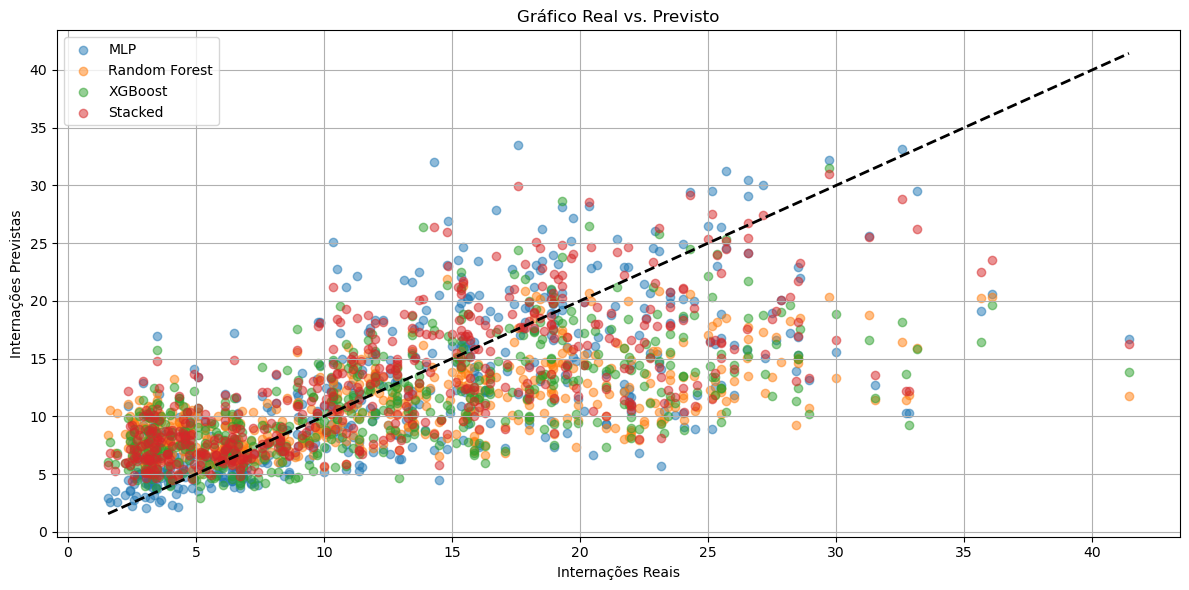

In [54]:
plt.figure(figsize=(12, 6))
for name, preds in model_preds.items():
    plt.scatter(y_test, preds, alpha=0.5, label=name)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel("Internações Reais")
plt.ylabel("Internações Previstas")
plt.title("Gráfico Real vs. Previsto")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Resíduos

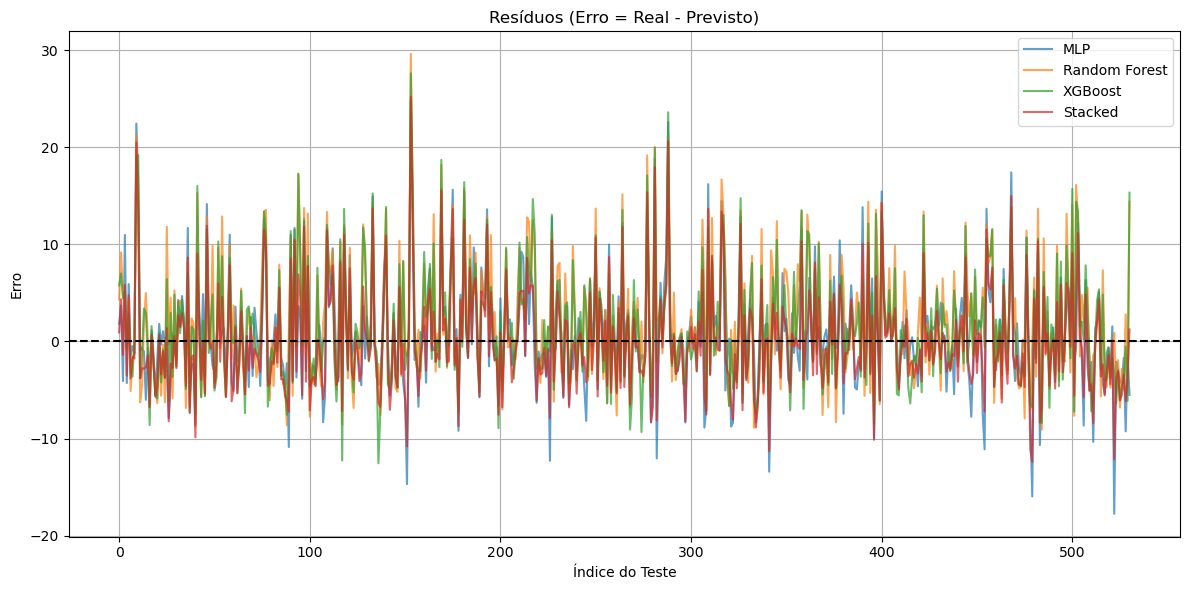

In [55]:
plt.figure(figsize=(12, 6))
for name, preds in model_preds.items():
    resid = y_test - preds
    plt.plot(resid, label=name, alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.title("Resíduos (Erro = Real - Previsto)")
plt.xlabel("Índice do Teste")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Histograma dos resíduos

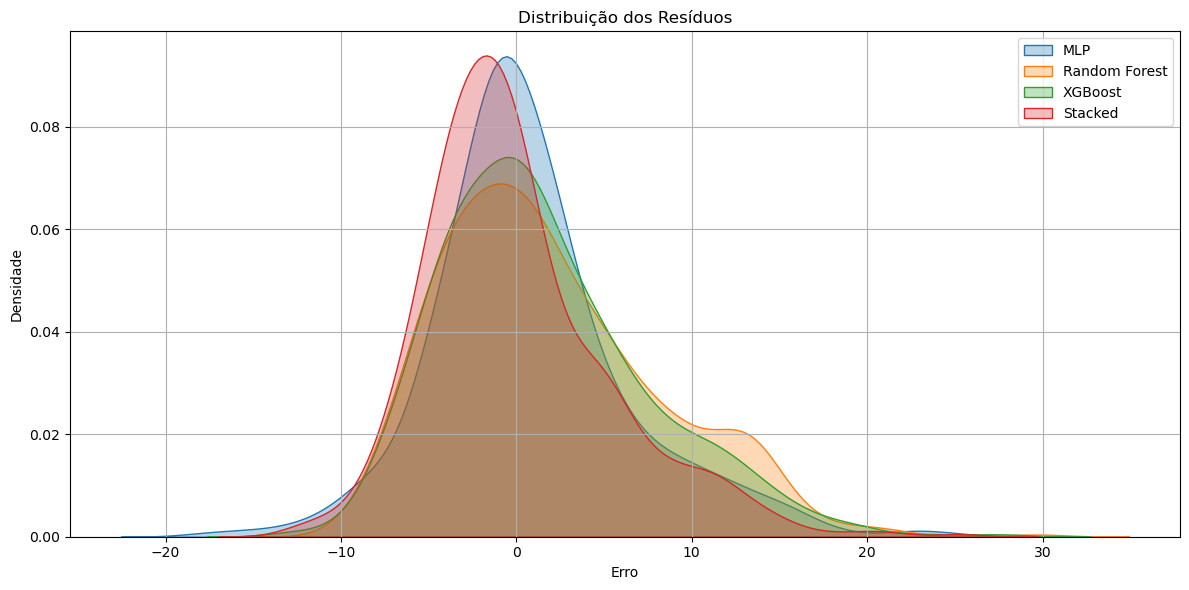

In [56]:
plt.figure(figsize=(12, 6))
for name, preds in model_preds.items():
    resid = y_test - preds
    sns.kdeplot(resid, label=name, fill=True, alpha=0.3)
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Top 10 erros absolutos

In [57]:
erros = np.abs(y_test - stack_pred)
top_erros = pd.DataFrame({
    'Internações Reais': y_test,
    'Internações Previstas (Stacked)': stack_pred,
    'Erro Absoluto': erros
}).sort_values(by='Erro Absoluto', ascending=False).head(10)

print("\n Top 10 maiores erros absolutos (modelo Stacked):")
print(top_erros)


 Top 10 maiores erros absolutos (modelo Stacked):
     Internações Reais  Internações Previstas (Stacked)  Erro Absoluto
153          41.428571                        16.221873      25.206698
288          32.857143                        12.212226      20.644917
9            32.714286                        12.208752      20.505534
281          31.500000                        13.558718      17.941282
169          28.928571                        13.352294      15.576278
277          28.428571                        13.060945      15.367626
468          23.142857                         8.165110      14.977748
400          22.285714                         8.009122      14.276592
133          24.071429                        10.349164      13.722264
309          25.142857                        11.466375      13.676482


In [58]:
# Criação do gráfico interativo
fig = go.Figure()

# Linha real
fig.add_trace(go.Scatter(
    y=y_test,
    mode='lines',
    name='Real',
    line=dict(color='black', width=2)
))

# Linha predita pelo modelo Stacked
fig.add_trace(go.Scatter(
    y=stack_pred,
    mode='lines',
    name='Stacked',
    line=dict(dash='dash', color='blue')
))

# Layout do gráfico
fig.update_layout(
    title='Comparação entre valores reais e preditos (Stacked Model)',
    xaxis_title='Dias',
    yaxis_title='Número de internações (internacoes_14d)',
    legend=dict(x=0, y=1),
    hovermode='x unified',
    template='plotly_white',
    height=500,
    width=1000
)

fig.show()


##  Prevendo `internacoes_14d` Apenas com os Lags Mais Importantes de Cada Variável

Nesta fase final, o modelo foi reestruturado para utilizar **exclusivamente a melhor versão de cada variável** — ou seja, apenas o atributo com maior importância entre a forma original e seus lags (1 a 3 dias), conforme identificado na etapa anterior.

### Objetivo:
- Reduzir a dimensionalidade do modelo.
- Manter o máximo de poder preditivo com o mínimo de variáveis.
- Testar se uma seleção mais enxuta melhora ou mantém o desempenho dos modelos.

### Estratégia:
- Foram mantidas apenas 11 variáveis (uma por grupo), cada uma representando sua melhor versão.
- O pipeline completo de modelagem (MLP, Random Forest, XGBoost e Stacked) foi reaplicado usando essa nova seleção.

### Resultados:
Apesar da redução de complexidade, observou-se uma **queda no desempenho geral** dos modelos em comparação à etapa anterior. Isso indica que, embora a simplificação torne o modelo mais interpretável e leve, **alguns lags “menos importantes” ainda carregavam informações complementares úteis para a previsão da `internacoes_14d`**.

Ainda assim, os resultados permaneceram consistentes, com o modelo Stacked novamente entregando o menor erro dentre os avaliados — reforçando seu papel como abordagem robusta para cenários com múltiplas fontes de informação.



In [59]:
#@title features mais relevantes

selected_features = list(best_lags.values())

selected_features

['pm2_5',
 'pm10_d3',
 'o3',
 'so2',
 'no2',
 'co',
 'no',
 'nox',
 'temp',
 'chuva',
 'ur']

In [60]:
# Selecionando dados finais
df_model = df[selected_features + ['internacoes_14d']].dropna()
X = df_model[selected_features].values
y = df_model['internacoes_14d'].values
y_log = np.log1p(y)

X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

def train_mlp(loss_function):
    model = MLP(X_train_scaled.shape[1])
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_log, dtype=torch.float32).view(-1, 1)

    best_val_loss = float('inf')
    best_state = None
    early_stop = 0

    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train_tensor)
        loss = loss_function(pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = loss_function(val_pred, y_val_tensor)
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_state = model.state_dict()
                early_stop = 0
            else:
                early_stop += 1
            if early_stop >= 50:
                break
        scheduler.step(val_loss)

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_pred_log = model(X_test_tensor).numpy().flatten()
        y_pred = np.expm1(y_pred_log)
    return y_pred

print("Treinando MLP...")
mlp_pred = train_mlp(nn.MSELoss())

print("Treinando Random Forest...")
rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
rf.fit(X_train_scaled, y_train_log)
rf_pred = np.expm1(rf.predict(X_test_scaled))

print("Treinando XGBoost...")
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
xgb.fit(X_train_scaled, y_train_log)
xgb_pred = np.expm1(xgb.predict(X_test_scaled))

print("Treinando Stacking...")
stack_input = np.vstack([mlp_pred, rf_pred, xgb_pred]).T
y_test = np.expm1(y_test_log)
stack_model = LinearRegression().fit(stack_input, y_test)
stack_pred = stack_model.predict(stack_input)

def avaliar(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)
    return {
        'RMSE': round(rmse, 2),
        'MAE': round(mean_absolute_error(y_true, y_pred), 2),
        'MAPE (%)': round(mean_absolute_percentage_error(y_true, y_pred) * 100, 2),
        'RMSE Normalizado': round(rmse / np.mean(y_true), 4)
    }

results = {
    "MLP (log1p)": avaliar(y_test, mlp_pred),
    "Random Forest (log1p)": avaliar(y_test, rf_pred),
    "XGBoost (log1p)": avaliar(y_test, xgb_pred),
    "Stacked Model": avaliar(y_test, stack_pred)
}

df_resultados = pd.DataFrame(results).T
print("\n Comparação de Modelos com Lags Selecionados ")
print(df_resultados)


Treinando MLP...
Treinando Random Forest...
Treinando XGBoost...
Treinando Stacking...

 Comparação de Modelos com Lags Selecionados 
                        RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP (log1p)            46.64  5.15     56.29            3.7176
Random Forest (log1p)  46.85  5.15     59.81            3.7340
XGBoost (log1p)        42.96  4.96     55.18            3.4237
Stacked Model          39.55  4.96     65.29            3.1521


# Teste 2 - Tentando prever o num_internacoes a partir da internacoes_14d

## Consumindo a base

In [38]:
# Carregar a base
url_internacoes_poluentes = 'https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/NEW_TEST/internacoes_x_poluentes_csv.csv'

df = pd.read_csv(url_internacoes_poluentes, sep=',')

In [39]:
#@title Criar média móvel de 14 dias

df['internacoes_14d'] = df['num_internacoes'].rolling(window=14).mean()

# Criar lags das variáveis ambientais
for lag in [1, 2, 3, 4, 5, 6, 7]:
    for col in ['pm2_5', 'pm10', 'o3', 'so2', 'no2', 'co', 'no', 'nox', 'temp', 'chuva', 'ur']:
        df[f'{col}_d{lag}'] = df[col].shift(lag)

## Separação dos dados

In [40]:
df.dropna(inplace=True)

# Separar variáveis para prever internacoes_14d
features = [col for col in df.columns if col not in ['data_formatada', 'classificacao', 'num_internacoes', 'ano', 'mes', 'internacoes_14d']]
X = df[features].values
y = np.log1p(df['internacoes_14d'].values)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## treinando modelo para prever `internacoes_14d`

In [41]:
# Treinar modelos para prever internacoes_14d
print("Treinando Random Forest para internacoes_14d...")
rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = np.expm1(rf.predict(X_test_scaled))

print("Treinando XGBoost para internacoes_14d...")
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
xgb.fit(X_train_scaled, y_train)
xgb_pred = np.expm1(xgb.predict(X_test_scaled))

print("Treinando Regressão Linear para internacoes_14d...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = np.expm1(lr.predict(X_test_scaled))

# Stacking para internacoes_14d
print("Treinando modelo empilhado (stacking) para internacoes_14d...")
stack_input = np.vstack([rf_pred, xgb_pred, lr_pred]).T
y_test_original = np.expm1(y_test)
stack_model = LinearRegression()
stack_model.fit(stack_input, y_test_original)
internacoes_14d_predita = stack_model.predict(stack_input)

Treinando Random Forest para internacoes_14d...
Treinando XGBoost para internacoes_14d...
Treinando Regressão Linear para internacoes_14d (como substituto do MLP)...
Treinando modelo empilhado (stacking) para internacoes_14d...


## Prevendo num_internacoes com internacoes_14d_predita + features originais

In [42]:
#@title Separando os dados

X_nova = np.concatenate([internacoes_14d_predita.reshape(-1, 1), X_test], axis=1)
y_final = np.log1p(df['num_internacoes'].values[-len(X_test):])

scaler2 = StandardScaler()
X_nova_scaled = scaler2.fit_transform(X_nova)

### Treinamento do modelo

In [43]:
# Modelos para prever num_internacoes
rf2 = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
rf2.fit(X_nova_scaled, y_final)
rf2_pred = np.expm1(rf2.predict(X_nova_scaled))

xgb2 = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
xgb2.fit(X_nova_scaled, y_final)
xgb2_pred = np.expm1(xgb2.predict(X_nova_scaled))

lr2 = LinearRegression()
lr2.fit(X_nova_scaled, y_final)
lr2_pred = np.expm1(lr2.predict(X_nova_scaled))

# Empilhamento final
stack_input_final = np.vstack([rf2_pred, xgb2_pred, lr2_pred]).T
y_true_final = np.expm1(y_final)
stack_final = LinearRegression().fit(stack_input_final, y_true_final)
stack_pred_final = stack_final.predict(stack_input_final)

### Avaliação do modelo

In [44]:
# Avaliação final
def avaliar(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)
    return {
        'RMSE': round(rmse, 2),
        'MAE': round(mean_absolute_error(y_true, y_pred), 2),
        'MAPE (%)': round(mean_absolute_percentage_error(y_true, y_pred) * 100, 2),
        'RMSE Normalizado': round(rmse / np.mean(y_true), 4)
    }

resultados_finais = avaliar(y_true_final, stack_pred_final)

# Mostrar resultados
print("\n Avaliação Final da Predição de num_internacoes ")
for metrica, valor in resultados_finais.items():
    print(f"{metrica}: {valor}")


 Avaliação Final da Predição de num_internacoes 
RMSE: 0.14
MAE: 0.22
MAPE (%): 2.16
RMSE Normalizado: 0.0103


### Gráficos

In [45]:
#@title Importancia das variaveis

print("\n Importância das Variáveis - Random Forest ")
importancias_rf = rf2.feature_importances_
features_novos = ['internacoes_14d_prevista'] + features
importancia_rf_df = pd.DataFrame({
    'Variável': features_novos,
    'Importância': importancias_rf
}).sort_values(by='Importância', ascending=False)
print(importancia_rf_df.head(10))

print("\n Importância das Variáveis - XGBoost ")
importancias_xgb = xgb2.feature_importances_
importancia_xgb_df = pd.DataFrame({
    'Variável': features_novos,
    'Importância': importancias_xgb
}).sort_values(by='Importância', ascending=False)
print(importancia_xgb_df.head(10))


 Importância das Variáveis - Random Forest 
   Variável  Importância
59    o3_d5     0.021254
9        o3     0.019573
37    o3_d3     0.018247
3        ur     0.017598
78    ur_d6     0.017500
8       so2     0.016540
70    o3_d6     0.016467
29    co_d2     0.015763
81    o3_d7     0.015649
41    no_d3     0.015607

 Importância das Variáveis - XGBoost 
    Variável  Importância
78     ur_d6     0.022806
46  pm2_5_d4     0.019476
9         o3     0.019160
42    nox_d3     0.018093
59     o3_d5     0.017432
50    no2_d4     0.017362
68  pm2_5_d6     0.016609
54   temp_d4     0.016394
41     no_d3     0.016070
20    nox_d1     0.015203


In [46]:
#@title DataFrame com resultados

df_resultados = pd.DataFrame({
    'Previsto': stack_pred_final,
    'Real': y_true_final
})
df_resultados['Erro Absoluto'] = np.abs(df_resultados['Previsto'] - df_resultados['Real'])
df_resultados['Erro Percentual (%)'] = (df_resultados['Erro Absoluto'] / df_resultados['Real']) * 100
df_resultados['MAPE'] = mean_absolute_percentage_error(df_resultados['Real'], df_resultados['Previsto']) * 100

# Salvar CSV
df_resultados.to_csv('previsao_vs_real_com_mape.csv', index=False)
print("\nArquivo CSV salvo como: previsao_vs_real_com_mape.csv")


Arquivo CSV salvo como: previsao_vs_real_com_mape.csv


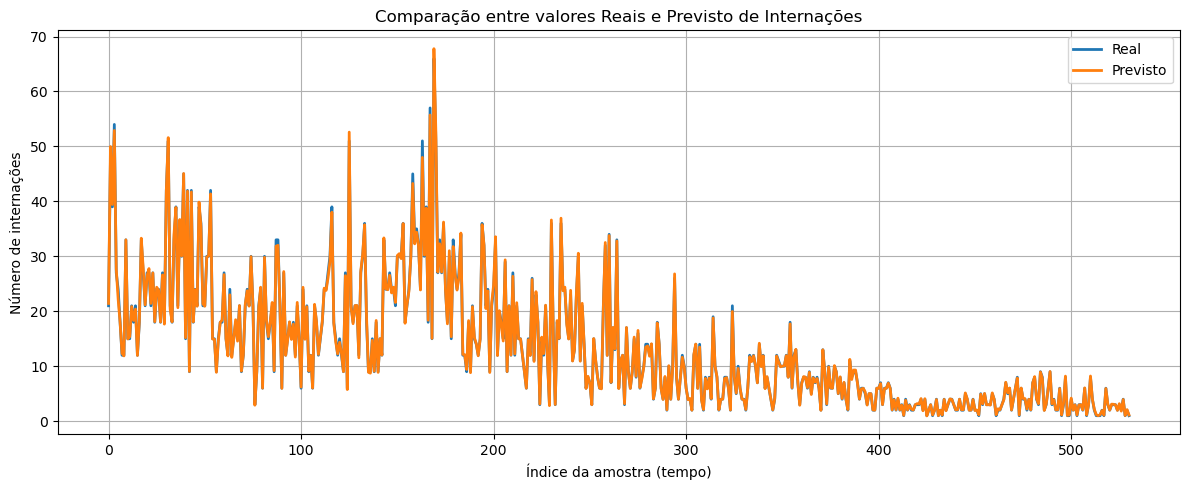

In [47]:
#@title Gráfico 1: Real vs Previsto (linha temporal)
plt.figure(figsize=(12, 5))
plt.plot(df_resultados['Real'].values, label='Real', linewidth=2)
plt.plot(df_resultados['Previsto'].values, label='Previsto', linewidth=2)
plt.title('Comparação entre valores Reais e Previsto de Internações')
plt.xlabel('Índice da amostra (tempo)')
plt.ylabel('Número de internações')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('grafico_real_vs_previsto.png')
plt.show()

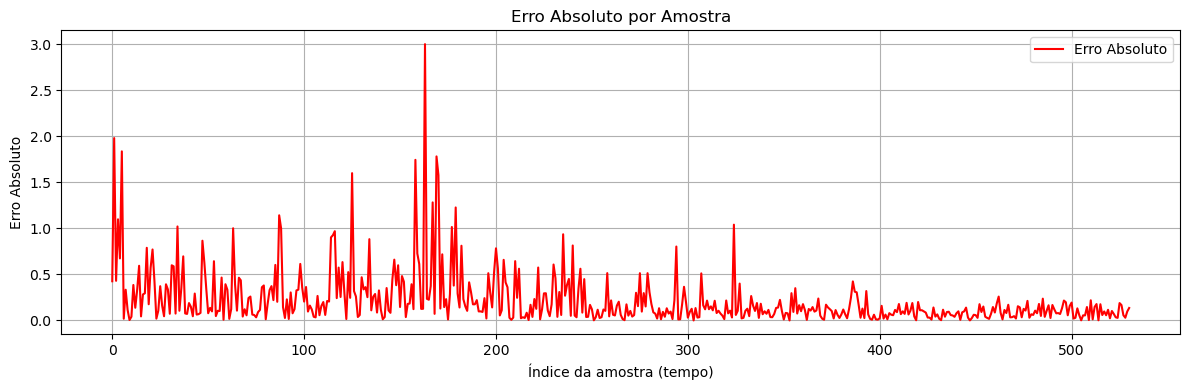

In [48]:
#@title Gráfico 2: Erro absoluto por amostra
plt.figure(figsize=(12, 4))
plt.plot(df_resultados['Erro Absoluto'].values, color='red', label='Erro Absoluto')
plt.title('Erro Absoluto por Amostra')
plt.xlabel('Índice da amostra (tempo)')
plt.ylabel('Erro Absoluto')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig('grafico_erro_absoluto.png')
plt.show()

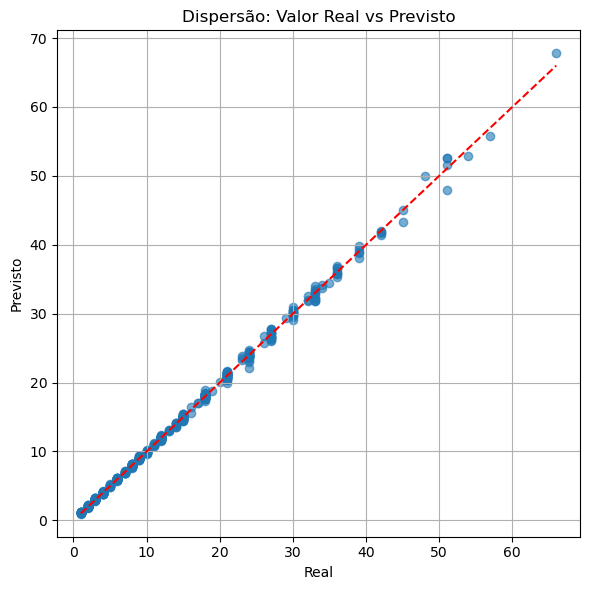

In [49]:
#@title Gráfico 3: Dispersão Real vs Previsto
plt.figure(figsize=(6, 6))
plt.scatter(df_resultados['Real'], df_resultados['Previsto'], alpha=0.6)
plt.plot([df_resultados['Real'].min(), df_resultados['Real'].max()],
         [df_resultados['Real'].min(), df_resultados['Real'].max()], 'r--')
plt.title('Dispersão: Valor Real vs Previsto')
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.grid(True)
plt.tight_layout()
plt.savefig('grafico_dispersao_real_previsto.png')
plt.show()

# Teste 3

## Consumindo bases

In [83]:
url_internacoes_poluentes = 'https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/NEW_TEST/internacoes_x_poluentes_csv.csv'

df = pd.read_csv(url_internacoes_poluentes, sep=',')

## Criação de novas features

### Lags de internação

In [84]:
df['internacoes_d1'] = df['num_internacoes'].shift(-1)
df['internacoes_d7'] = df['num_internacoes'].shift(-7)
df['internacoes_d14'] = df['num_internacoes'].shift(-14)

In [85]:
for lag in [1, 7, 14]:
    df[f'internacoes_lag{lag}'] = df['num_internacoes'].shift(lag)

### Lags dos poluentes e variáveis atmosfericas

In [86]:
for lag in [1, 3, 7]:
    for col in ['pm2_5', 'pm10', 'o3', 'so2', 'no2', 'co', 'no', 'nox', 'temp', 'chuva', 'ur']:
        df[f'{col}_d{lag}'] = df[col].shift(lag)

In [87]:
for col in ['pm2_5', 'pm10', 'o3', 'so2', 'no2', 'co', 'no', 'nox']:
    df[f'{col}_ma7'] = df[col].rolling(7).mean()
    df[f'{col}_ma14'] = df[col].rolling(14).mean()

### Sazonalidade

In [88]:
df['data_formatada'] = pd.to_datetime(df['data_formatada'])
df['dia_semana'] = df['data_formatada'].dt.weekday

## Predição de Diferentes Representações da Variável-Alvo

### MLP

In [89]:
df.dropna(inplace=True)

# Definição do modelo MLP
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.GELU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.GELU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.GELU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.model(x)

### Função para treinar e avaliar os modelos

In [90]:
def treinar_modelos_para_alvo(df, target):
    print(f"\nTreinando para variável alvo: {target}")

    features = [col for col in df.columns if col not in [
        'data_formatada', 'classificacao', 'ano', 'mes',
        'num_internacoes', 'internacoes_d1', 'internacoes_d7', 'internacoes_d14', target
    ]]

    X = df[features].values
    y = df[target].values
    y_log = np.log1p(y)

    X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
    X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # MLP
    model = MLP(X_train_scaled.shape[1])
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    loss_function = nn.HuberLoss()

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_log, dtype=torch.float32).view(-1, 1)

    best_val_loss = float('inf')
    best_state = model.state_dict()
    early_stop = 0
    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train_tensor)
        loss = loss_function(pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = loss_function(val_pred, y_val_tensor)
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_state = model.state_dict()
                early_stop = 0
            else:
                early_stop += 1
            if early_stop >= 50:
                break
        scheduler.step(val_loss)

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        mlp_pred_log = model(X_test_tensor).numpy().flatten()
        mlp_pred = np.expm1(mlp_pred_log)

    # Random Forest
    rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
    rf.fit(X_train_scaled, y_train_log)
    rf_pred_log = rf.predict(X_test_scaled)
    rf_pred = np.expm1(rf_pred_log)

    # XGBoost
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
    xgb.fit(X_train_scaled, y_train_log)
    xgb_pred_log = xgb.predict(X_test_scaled)
    xgb_pred = np.expm1(xgb_pred_log)

    # Stacking
    y_test = np.expm1(y_test_log)
    stack_input = np.vstack([mlp_pred, rf_pred, xgb_pred]).T
    stack_model = LinearRegression().fit(stack_input, y_test)
    stack_pred = stack_model.predict(stack_input)

    # Avaliação
    def avaliar(y_true, y_pred):
        rmse = mean_squared_error(y_true, y_pred)
        return {
            'RMSE': round(rmse, 2),
            'MAE': round(mean_absolute_error(y_true, y_pred), 2),
            'MAPE (%)': round(mean_absolute_percentage_error(y_true, y_pred) * 100, 2),
            'RMSE Normalizado': round(rmse / np.mean(y_true), 4)
        }

    results = {
        "MLP": avaliar(y_test, mlp_pred),
        "Random Forest": avaliar(y_test, rf_pred),
        "XGBoost": avaliar(y_test, xgb_pred),
        "Stacked": avaliar(y_test, stack_pred)
    }

    df_results = pd.DataFrame(results).T
    print(df_results)

    return df_results

### Executando para cada variável-alvo

In [91]:
alvos_futuros = ['internacoes_d1', 'internacoes_d7', 'internacoes_d14']
todos_resultados = {}

for alvo in alvos_futuros:
    resultados = treinar_modelos_para_alvo(df, alvo)
    todos_resultados[alvo] = resultados


Treinando para variável alvo: internacoes_d1
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            81.52  5.90     63.47            6.5669
Random Forest  72.48  5.46     64.73            5.8388
XGBoost        70.84  5.51     64.47            5.7062
Stacked        67.15  5.51     73.94            5.4095

Treinando para variável alvo: internacoes_d7
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            93.64  6.00     59.54            7.4400
Random Forest  86.52  5.78     61.37            6.8746
XGBoost        83.39  5.79     61.77            6.6255
Stacked        80.06  5.92     74.82            6.3616

Treinando para variável alvo: internacoes_d14
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            77.09  5.84     62.25            6.1910
Random Forest  70.57  5.59     63.99            5.6672
XGBoost        69.93  5.61     63.05            5.6157
Stacked        65.43  5.69     72.76            5.2548
